In [172]:
import torchvision as t
import torch
import numpy as np
import pandas as pd
import gpytorch
import math
from matplotlib import pyplot as plt
import urllib.request
import os.path
from scipy.io import loadmat
from math import floor
import time
import gc

Temp Code, don't load

In [61]:
'''
if not os.path.isfile('skillcraft.mat'):
    print('Downloading \'skillcraft\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1xQ1vgx_bOsLDQ3RLbJwPxMyJHW7U9Eqd', 'skillcraft.mat')
    
data = torch.Tensor(loadmat('skillcraft.mat')['data'])
X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

print(data.shape)


data=pd.read_csv('processed-data-2010.csv')

data=data.iloc[:temp]
temp=temp+500
y=torch.tensor(data['precipitation'].values,dtype=torch.float32)

X=torch.tensor(data[['station_id','year','month','day']].values,dtype=torch.float32)
'''

"\nif not os.path.isfile('skillcraft.mat'):\n    print('Downloading 'skillcraft' UCI dataset...')\n    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1xQ1vgx_bOsLDQ3RLbJwPxMyJHW7U9Eqd', 'skillcraft.mat')\n    \ndata = torch.Tensor(loadmat('skillcraft.mat')['data'])\nX = data[:, :-1]\nX = X - X.min(0)[0]\nX = 2 * (X / X.max(0)[0]) - 1\ny = data[:, -1]\n\nprint(data.shape)\n"

# The main code

In [191]:
temp=100
matrix_data=np.zeros((33,6))
i=0
while temp<=3300:
    
    if not os.path.isfile('skillcraft.mat'):
        #print('Downloading \'skillcraft\' UCI dataset...')
        urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1xQ1vgx_bOsLDQ3RLbJwPxMyJHW7U9Eqd', 'skillcraft.mat')
    
    
    data = torch.Tensor(loadmat('skillcraft.mat')['data'])
    '''
    print(data)
    X = data[:, :-1]
    #X = X - X.min(0)[0]
    #X = 2 * (X / X.max(0)[0]) - 1
    y = data[:, -1]
    X=X.numpy()
    y=y.numpy()
    X=X[:temp]
    y=y[:temp]
    
    X = torch.linspace(0, 1, temp)
    # True function is sin(2*pi*x) with Gaussian noise
    y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2
    X=torch.Tensor(X)
    y=torch.Tensor(y)
    '''
    #print(y)
    #print(X)
    #print(data.shape)
    X = data[:, :-1]
    X = X - X.min(0)[0]
    X = 2 * (X / X.max(0)[0]) - 1
    y = data[:, -1]
    X=X.numpy()
    y=y.numpy()
    X=X[:temp]
    y=y[:temp]
    #print(y)
    X=torch.Tensor(X)
    y=torch.Tensor(y)
    # Use the first 80% of the data for training, and the last 20% for testing.
    train_n = int(floor(0.4*len(X)))

    train_x = X[:train_n,:].contiguous()
    train_y = y[:train_n].contiguous()

    test_x = X[train_n:,:].contiguous()
    test_y = y[train_n:].contiguous()

    class ExactGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 40
    def train():
        for i in range(training_iterations):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
            
            optimizer.step()
            temp=loss.item()
            return temp
    start_time = time.time()        
    err=train()

    time_train_without_smth= time.time() - start_time

    # Set into eval mode
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        start_time = time.time()
        preds = model(test_x)
        exact_covar = preds.covariance_matrix
        exact_covar_time = time.time() - start_time
    #print('Time to compute exact mean + covariances: {:.2f}s'.format(exact_covar_time))
    # Clear as much 'stuff' as possible
    gc.collect()
    torch.cuda.empty_cache()
    model.train()
    likelihood.train()

    # Set into eval mode
    model.eval()
    likelihood.eval()

    # The 
    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(25):
        start_time = time.time()
        preds = model(test_x)
        fast_time_no_cache = time.time() - start_time
    
    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(25):
        start_time = time.time()
        preds = model(test_x)
        fast_covar = preds.covariance_matrix
        fast_time_with_cache = time.time() - start_time
    
    print(temp)
    print('Time to compute exact mean + covariances: {:.2f}s'.format(exact_covar_time))
    #print('Time to compute without uskorenie {:.2f}s'.format(time_train_without_smth))
    print('Time to compute mean + covariances (no cache) {:.2f}s'.format(fast_time_no_cache))
    #print('Time to compute mean + variances (cache): {:.2f}s'.format(fast_time_with_cache))
    print('MAE between exact covar matrix and fast covar matrix: {}'.format((exact_covar - fast_covar).abs().mean()))
    #print(np.array(preds.loc))
    #print(test_y.numpy()) 
    print('accur: {}'.format(np.linalg.norm(np.array(preds.loc)-test_y.numpy())))
    #np.linalg.norm(np.array(preds.loc)-test_y.numpy())
    matrix_data[i]=[temp,time_train_without_smth,fast_time_no_cache,(exact_covar - fast_covar).abs().mean(),err,(training_iterations+temp*math.log(temp))*0.01]
    i=i+1
    temp=temp+100
dd=pd.DataFrame({'N':matrix_data[:,0],'without':matrix_data[:,1],'with':matrix_data[:,2],'accuracy_cov':matrix_data[:,3],'accur':matrix_data[:,4],'nlogn':matrix_data[:,5]})
dd.to_excel('data.xlsx')
#print(matrix_data)

100
Time to compute exact mean + covariances: 0.07s
Time to compute mean + covariances (no cache) 0.01s
MAE between exact covar matrix and fast covar matrix: 0.002259771106764674
accur: 2.7487595081329346
200
Time to compute exact mean + covariances: 0.03s
Time to compute mean + covariances (no cache) 0.02s
MAE between exact covar matrix and fast covar matrix: 0.004840988200157881
accur: 3.2642571926116943
300
Time to compute exact mean + covariances: 0.04s
Time to compute mean + covariances (no cache) 0.02s
MAE between exact covar matrix and fast covar matrix: 0.006442416459321976
accur: 3.5419795513153076
400
Time to compute exact mean + covariances: 0.06s
Time to compute mean + covariances (no cache) 0.03s
MAE between exact covar matrix and fast covar matrix: 0.007098626345396042
accur: 4.159011363983154
500
Time to compute exact mean + covariances: 0.08s
Time to compute mean + covariances (no cache) 0.04s
MAE between exact covar matrix and fast covar matrix: 0.0076753925532102585
a

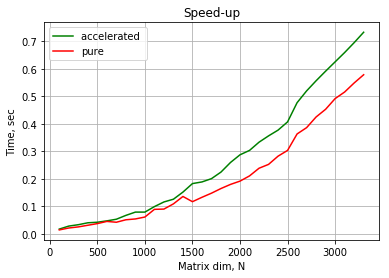

In [192]:
plt.title('Speed-up')
plt.plot(dd['N'].tolist(),dd['without'].tolist(),label='green',color='green')
plt.plot(dd['N'].tolist(),dd['with'].tolist(),label='red',color='red')
#plt.plot(dd['N'].tolist(),(dd['nlogn']*0.01).tolist())
plt.legend(['accelerated ','pure'])
plt.xlabel('Matrix dim, N')
plt.ylabel('Time, sec')
plt.grid(True)
#plt.show()
plt.savefig('Speed-up')

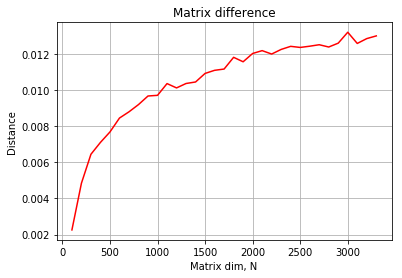

In [193]:
plt.title('Matrix difference')
plt.plot(dd['N'].tolist(),dd['accuracy_cov'].tolist(),label='red',color='red')
#plt.plot(dd['N'].tolist(),(dd['nlogn']*0.01).tolist())
plt.xlabel('Matrix dim, N')
plt.ylabel('Distance')
plt.grid(True)
#plt.show()
plt.savefig('Matrix_diff')

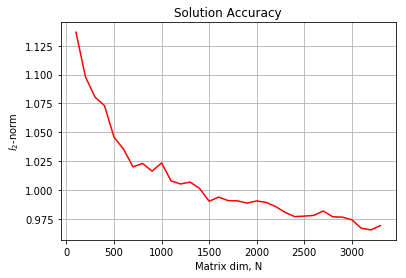

In [194]:
plt.title('Solution Accuracy')
plt.plot(dd['N'].tolist(),dd['accur'].tolist(),label='red',color='red')
plt.xlabel('Matrix dim, N')
plt.ylabel('$l_2$-norm')
#plt.plot(dd['N'].tolist(),(dd['nlogn']*0.01).tolist())
plt.grid(True)
#plt.show()
plt.savefig('Solution_acc')

# For Lanczos iteration

In [195]:
 
if not os.path.isfile('skillcraft.mat'):
    #print('Downloading \'skillcraft\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1xQ1vgx_bOsLDQ3RLbJwPxMyJHW7U9Eqd', 'skillcraft.mat')


data = torch.Tensor(loadmat('skillcraft.mat')['data'])

#print(y)
#print(X)
#print(data.shape)
X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]
# Use the first 80% of the data for training, and the last 20% for testing.
train_n = int(floor(0.4*len(X)))

train_x = X[:train_n,:].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:,:].contiguous()
test_y = y[train_n:].contiguous()

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

temp=10
matrix_data=np.zeros((100,2))
i=0 
while temp<=1000:
    def train():
        for i in range(training_iterations):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))

            optimizer.step()
            temp=loss.item()
            return temp
    start_time = time.time()        
    err=train()
    matrix_data[i]=[temp,err]
    i=i+1
    temp=temp+10
dd=pd.DataFrame({'iter':matrix_data[:,0],'err':matrix_data[:,1]})
dd.to_excel('data_ert.xlsx')
#sprint(dd)
time_train_without_smth= time.time() - start_time

# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    start_time = time.time()
    preds = model(test_x)
    exact_covar = preds.covariance_matrix
    exact_covar_time = time.time() - start_time
#print('Time to compute exact mean + covariances: {:.2f}s'.format(exact_covar_time))
# Clear as much 'stuff' as possible
gc.collect()
torch.cuda.empty_cache()
model.train()
likelihood.train()

# Set into eval mode
model.eval()
likelihood.eval()

# The 
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(25):
    start_time = time.time()
    preds = model(test_x)
    fast_time_no_cache = time.time() - start_time

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(25):
    start_time = time.time()
    preds = model(test_x)
    fast_covar = preds.covariance_matrix
    fast_time_with_cache = time.time() - start_time

print(temp)
print('Time to compute exact mean + covariances: {:.2f}s'.format(exact_covar_time))
#print('Time to compute without uskorenie {:.2f}s'.format(time_train_without_smth))
print('Time to compute mean + covariances (no cache) {:.2f}s'.format(fast_time_no_cache))
#print('Time to compute mean + variances (cache): {:.2f}s'.format(fast_time_with_cache))
print('MAE between exact covar matrix and fast covar matrix: {}'.format((exact_covar - fast_covar).abs().mean()))
#print(np.array(preds.loc))
#print(test_y.numpy()) 
print('accur: {}'.format(np.linalg.norm(np.array(preds.loc)-test_y.numpy())))
#np.linalg.norm(np.array(preds.loc)-test_y.numpy())

#print(matrix_data)

1010
Time to compute exact mean + covariances: 4.45s
Time to compute mean + covariances (no cache) 0.64s
MAE between exact covar matrix and fast covar matrix: 0.0004715483810286969
accur: 11.354987144470215


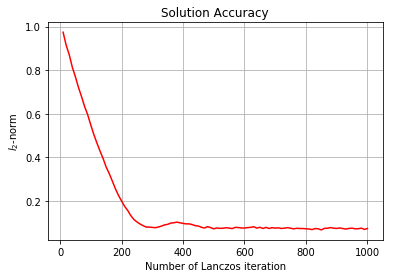

In [196]:
plt.title('Solution Accuracy')
plt.plot(dd['iter'].tolist(),dd['err'].tolist(),label='red',color='red')
plt.xlabel('Number of Lanczos iteration')
plt.ylabel('$l_2$-norm')
#plt.plot(dd['N'].tolist(),(dd['nlogn']*0.01).tolist())
plt.grid(True)
#plt.show()
plt.savefig('Number of Lanczos iter')